<a href="https://colab.research.google.com/github/Vcarmelli/Peptide-Generation/blob/main/FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install hf_xet --quiet
!pip install transformers peft accelerate bitsandbytes --quiet
!pip install nltk --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.0 MB/s eta 0:00:00


In [3]:
#@title Load Model and LORA Adapters

from transformers import T5Tokenizer, T5ForConditionalGeneration, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType # Parameter-efficient fine-tuning (peft)

bnb_config = BitsAndBytesConfig(load_in_8bit=True)  # memory saver load model in lower bit
model = T5ForConditionalGeneration.from_pretrained(
    "Rostlab/prot_t5_xl_uniref50",
    quantization_config=bnb_config,
    device_map="auto"
)
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False)

# Apply LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
    target_modules=["q", "v"]  # typical for T5 attention
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


trainable params: 5,898,240 || all params: 2,824,728,576 || trainable%: 0.2088


In [4]:
#@title Pre-process data
import pandas as pd

csv_folder = "/content/drive/MyDrive/csv/Final Datasets"
df = pd.read_csv(f'{csv_folder}/peptides_with_labels.csv')

def preprocess(row):
    target = row["Target"]
    sequence = ' '.join(list(row["Sequence"]))  # space between amino acids
    inhibition = row["IC50"] if pd.notna(row["IC50"]) else 0
    return pd.Series([target, sequence, inhibition])

df[['Target', 'Peptide', 'Inhibition']] = df.apply(preprocess, axis=1)
df = df[['Target', 'Peptide', 'Inhibition']]
df.head()

,Target,Peptide,Inhibition
0,1,G Q G K A H N G R L I T A N P,33.0
1,2,G Q G K A H N G R L I T A N P,10.0
2,3,G Q G K A H N G R L I T A N P,20.0
3,4,G Q G K A H N G R L I T A N P,20.0
4,1,D R G W G N G C G L F G,10.0


In [5]:
#@title Build Dataset
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torch

class PeptideDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.inputs = dataframe['Target'].tolist()
        self.peptides = dataframe['Peptide'].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_text = f"serotype: {self.inputs[idx]}"
        target_text = f"peptide: {self.peptides[idx]}"

        input_enc = tokenizer(input_text, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        target_enc = tokenizer(target_text, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        labels = target_enc["input_ids"].squeeze()
        labels[labels == tokenizer.pad_token_id] = -100  # mask padding
        return {
            "input_ids": input_enc["input_ids"].squeeze(),
            "attention_mask": input_enc["attention_mask"].squeeze(),
            "labels": labels
        }

# Split training and validation datasets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = PeptideDataset(train_df, tokenizer)
val_dataset = PeptideDataset(val_df, tokenizer)

print("Train data:", len(train_dataset))
print("Validation data:", len(val_dataset))

Train data: 132
Validation data: 33


In [6]:
#@title Train ProtT5 Model with Early Stopping
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

early_stop = EarlyStoppingCallback(
    early_stopping_patience=2,  # Stop after 2 evals with no improvement
    early_stopping_threshold=0.001  # Optional: min improvement required
)

training_args = TrainingArguments(
    output_dir="./protT5-lora-peptide",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=2,  # simulate like batch_size=2
    num_train_epochs=10,
    learning_rate=5e-4,
    logging_strategy="epoch",
    save_total_limit=1,
    fp16=False,
    bf16=False,
    optim="adamw_torch", # lighter optimizer
    lr_scheduler_type="linear",
    save_strategy="epoch",
    eval_strategy="epoch",
    eval_steps=10,
    logging_dir="./logs",
    load_best_model_at_end=True,
    greater_is_better=False,  # Lower loss is better
    report_to="none",   # no wandb/logging crashes
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stop]
)

trainer.train()

No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,4.535900,3.009766
2,2.967900,2.820312
3,2.736800,2.689453
4,2.566500,2.560547
5,2.357500,2.375000
6,2.167900,2.328125
7,2.035200,2.246094
8,1.866500,2.228516
9,1.802000,2.117188
10,1.717700,2.154297


TrainOutput(global_step=660, training_loss=2.4753983931107952, metrics={'train_runtime': 956.3781, 'train_samples_per_second': 1.38, 'train_steps_per_second': 0.69, 'total_flos': 2863461889474560.0, 'train_loss': 2.4753983931107952, 'epoch': 10.0})

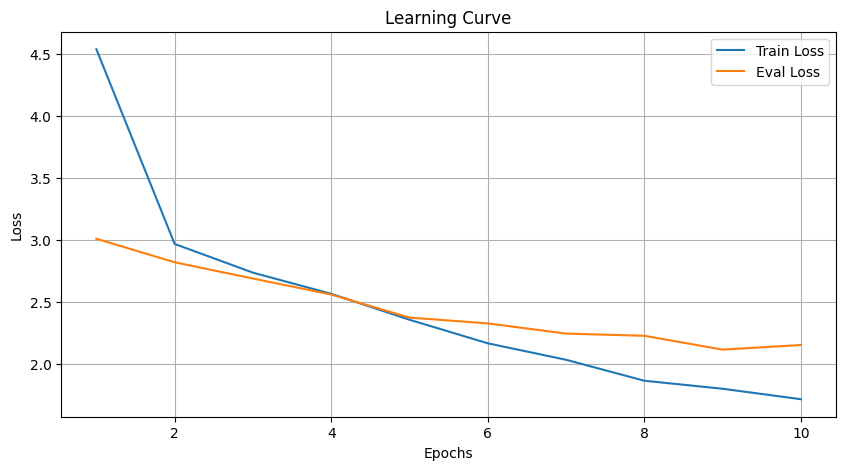

In [7]:
#@title Plot Model's Learning Curve

import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curves(trainer):
    logs = trainer.state.log_history
    train_loss = [entry["loss"] for entry in logs if "loss" in entry]
    eval_loss = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]
    steps = [entry["epoch"] for entry in logs if "loss" in entry]

    plt.figure(figsize=(10, 5))
    plt.plot(steps, train_loss, label="Train Loss")
    if eval_loss:
        eval_steps = [entry["epoch"] for entry in logs if "eval_loss" in entry]
        plt.plot(eval_steps, eval_loss, label="Eval Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(trainer)

In [21]:
#@title Start Peptide Generation

def generate_peptides(serotype, seq_length=100, num_of_sequences=5):
    prompt = f"serotype: {serotype}"
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)

    # Generate sequences
    output_ids = model.generate(
        input_ids=input_ids,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=1,
        max_length=seq_length,
        num_return_sequences=num_of_sequences,
        repetition_penalty=1.8,
    )

    # Save and clean results
    peptides = []
    print(f"Serotype {serotype}:")
    for i, out in enumerate(output_ids):
        decoded = tokenizer.decode(out, skip_special_tokens=True)
        peptide = decoded.replace(" ", "")
        peptides.append({
            "serotype": serotype,
            "sequence_id": i+1,
            "peptide": peptide
        })
        print(f"  {i+1}. Peptide: {peptide}")
    print()

    return pd.DataFrame(peptides)


# Generate for each serotypes
all = []
for serotype in ["1", "2", "3", "4"]:
    new = generate_peptides(serotype, seq_length=200, num_of_sequences=10)
    all.append(new)

peptides_df = pd.concat(all, ignore_index=True)
peptides_df.head()

Serotype 1:
  1. Peptide: RRRRHVCWY
  2. Peptide: RRRRIGCGY
  3. Peptide: LACF
  4. Peptide: RRRKSXXL
  5. Peptide: LRRRH
  6. Peptide: LGRRKSXIF
  7. Peptide: GKRKSXHF
  8. Peptide: AKRPW
  9. Peptide: RRRRITW
  10. Peptide: RRRRHCCC

Serotype 2:
  1. Peptide: LWGCG
  2. Peptide: LKRR
  3. Peptide: OAEGKRPY
  4. Peptide: LWACH
  5. Peptide: LRRKR
  6. Peptide: GKRKSXSF
  7. Peptide: LRRRR
  8. Peptide: HEWLHIGDFNR
  9. Peptide: GKRKSXXF
  10. Peptide: AKRRW

Serotype 3:
  1. Peptide: PKRAN
  2. Peptide: LKRRH
  3. Peptide: CGYARC
  4. Peptide: EVLPKRKH
  5. Peptide: RLERSKTY
  6. Peptide: RRRRXGXF
  7. Peptide: LKRRH
  8. Peptide: RRRKFXXC
  9. Peptide: RRRRHCCY
  10. Peptide: ALGRR

Serotype 4:
  1. Peptide: GKRKSXSF
  2. Peptide: HRRRRGWWWC
  3. Peptide: RRRRYYCXY
  4. Peptide: LKRRH
  5. Peptide: LKSR
  6. Peptide: RRRRHWCW
  7. Peptide: LRRRR
  8. Peptide: RRRRPCY
  9. Peptide: RRRKXXC
  10. Peptide: KRRH



,serotype,sequence_id,peptide
0,1,1,RRRRHVCWY
1,1,2,RRRRIGCGY
2,1,3,LACF
3,1,4,RRRKSXXL
4,1,5,LRRRH


In [9]:
#@title Prepare Datasets for Inhibition Prediction
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


def get_peptide_features(peptides):
    """Convert peptides to n-gram features"""
    vectorizer = CountVectorizer(
        analyzer='char',
        ngram_range=(1, 3),  # Single AAs + di/tri-peptides
        lowercase=False
    )
    return vectorizer.fit_transform(peptides)

df['Peptide'] = df['Peptide'].apply(lambda x: ' '.join(list(x)))

# Stack embeddings
X = get_peptide_features(df['Peptide'])
y = df["Inhibition"].values

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# With ProtT5 embeddings
rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train, y_train)

# Evaluate
preds = rf.predict(X_val)
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, preds)):.3f}")

RMSE: 135.568


In [11]:
def preprocess_generated(row):
    """Convert peptides to n-gram features"""
    vectorizer = CountVectorizer(
        analyzer='char',
        ngram_range=(1, 3),  # Single AAs + di/tri-peptides
        lowercase=False
    )
    return vectorizer.fit_transform([row['peptide']])



peptides_df['embeddings'] = peptides_df.apply(preprocess_generated, axis=1)
peptides_df = peptides_df[['serotype', 'sequence_id', 'peptide', 'embeddings']]
peptides_df.head()

,serotype,sequence_id,peptide,embeddings
0,1,1,RWGCG,<Compressed Sparse Row sparse matrix of dtype ...
1,1,2,RRRRFCW,<Compressed Sparse Row sparse matrix of dtype ...
2,1,3,LHRRRRAGCW,<Compressed Sparse Row sparse matrix of dtype ...
3,1,4,AHKRKH,<Compressed Sparse Row sparse matrix of dtype ...
4,1,5,SGRRH,<Compressed Sparse Row sparse matrix of dtype ...


In [18]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from scipy.sparse import csr_matrix

def pad_embedding(e, length=394):
    if hasattr(e, 'toarray'):
        e = e.toarray().flatten()
    else:
        e = np.array(e).flatten()

    padded = np.zeros(length)
    n = min(e.shape[0], length)
    padded[:n] = e[:n]
    return padded

X_new = np.stack([pad_embedding(e, length=394) for e in peptides_df["embeddings"]])
peptides_df["predicted_inhibition"] = rf.predict(X_new)

In [20]:
peptides_df

,serotype,sequence_id,peptide,embeddings,predicted_inhibition
0,1,1,RWGCG,<Compressed Sparse Row sparse matrix of dtype ...,108.990050
1,1,2,RRRRFCW,<Compressed Sparse Row sparse matrix of dtype ...,124.550000
2,1,3,LHRRRRAGCW,<Compressed Sparse Row sparse matrix of dtype ...,213.266893
3,1,4,AHKRKH,<Compressed Sparse Row sparse matrix of dtype ...,185.238650
4,1,5,SGRRH,<Compressed Sparse Row sparse matrix of dtype ...,108.910050
5,1,6,LRRRR,<Compressed Sparse Row sparse matrix of dtype ...,82.657350
6,1,7,GKRKSXSL,<Compressed Sparse Row sparse matrix of dtype ...,189.338993
7,1,8,ASHGKRXSV,<Compressed Sparse Row sparse matrix of dtype ...,208.919393
8,1,9,RRRRHYCWTSL,<Compressed Sparse Row sparse matrix of dtype ...,248.544293
9,1,10,BAGKH,<Compressed Sparse Row sparse matrix of dtype ...,124.550000



Usage limit

---

After generating peptides tried predicting inhibition using random forest regressor

Features from prott5 embed same sa lahat ng sequence, even prediction nagiging same same din,  so di natinuloy

Tried features in sklearn text, cant proceed pa